# Using Virtual Data Stores to Compare Sea Surface Temperature Gradients
#### *Author: Celia Ou, PO.DAAC*

## Summary
This notebook demonstrates how to open, subset, and compute the horizontal gradients of the [MUR SST](https://doi.org/10.5067/GHGMR-4FJ04) and [OSTIA](https://doi.org/10.5067/GHOST-4RM02) SST satellite data products, using the virtual dataset versions of these datasets available from PO.DAAC. The gradient computations follow the first few calculations and figures described in [this article](doi.org/10.3390/rs17152722) on the application of satellite-derived sea surface temperature gradients to examine seasonal and interannual variability off the California Coast. Documentation for the implementation of the MUR dataset can be found [in this design doc](https://github.com/earth-mover/icechunk-nasa/blob/main/design-docs/mursst-virtual-icechunk-store.md). For OSTIA and the usage of other PO.DAAC VDS's in general, see the [PO.DAAC Cookbook section on VDS](https://podaac.github.io/tutorials/quarto_text/UsingVirtualDatasets.html)

#### Sections
1. Examine the MUR dataset and compute SST gradient
2. Examine the OSTIA dataset and compute SST gradient
3. Interpolate MUR to OSTIA and compute the gradient for comparison

## Requirements

### Compute Environment
**AWS instance running in us-west-2**: NASA Earthdata Cloud data in S3 can be directly accessed via temporary credentials; this access is limited to requests made within the US West (Oregon) (code: `us-west-2`) AWS region.

**Keep in mind**: For out-of-cloud use, you may run into access errors if trying to do computations with more than ~20 years of data due to limitations on the number of simultaneous data requests that can be made at once. For complex or large computations with VDS's, please be in the cloud in the same location as the data (for PO.DAAC this is `us-west-2`).

### Earthdata Login
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.
    
### Key packages, and versions this notebook was developed using:
- boto3==1.40.18
- earthaccess==0.14.0
- fsspec==2025.9.0
- icechunk==1.1.5
- kerchunk==0.2.8
- virtualizarr==1.3.2
- xarray==2025.9.0
- zarr==3.0.8
- cf_pandas==0.8.1
- dask-geopandas==0.5.0
- geopandas==1.1.1
- matplotlib==3.10.6
- matplotlib-inline==0.1.7
- numpy==2.3.3
- numpy-groupies==0.11.3
- pandas==2.3.2
- scipy==1.16.2

### **Credential expiration**
The AWS credentials associated with Earthdata Login expire after an hour. If you run a cell and the error mentions something about an expired token near the bottom, then chances are that your token expired. A temporary solution is to re-run the cell containing earthaccess for that section, then resume your work by running only the cells you are working with next.

## Import packages

In [1]:
%%capture
!pip install icechunk==1.1.5 xarray==2025.9.0 zarr==3.0.8 earthaccess==0.14.0 kerchunk==0.2.8 virtualizarr==1.3.2 fsspec==2025.9.0 metpy cartopy

In [2]:
# Access
import earthaccess
import fsspec

# Reading and data handling
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import icechunk
from icechunk.credentials import s3_credentials
from typing import Optional
import metpy
import metpy.calc as mpcalc
from metpy.units import units

# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### Set the region and time range for both MUR and OSTIA datasets

In [3]:
# Bounding box for a region off the coast of California
lat_min = 30.
lat_max = 45.
lon_min = -140.
lon_max = -115.

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

##3 years
start_date = '2010-01-01'
end_date = '2012-12-31'

# # 10 years
# start_date = '2010-01-01'
# end_date = '2019-12-31'

# # 20 years
# start_date = '2002-09-01'
# end_date = '2022-08-31'

time_range =(start_date, end_date)

#### Set zarr runtime configuration

Async and threading operations can be set via zarr.config. Please also see [zarr-python runtime configuration documentation](https://zarr.readthedocs.io/en/stable/user-guide/config.html).

* `async.concurrency` controls how many chunks can be fetched asynchronously at once.
* `threading.max_workers` determines how many threads handle the decompression or processing of those fetched chunks.

The default setting for `threading.max_workers` is `None` so presumably this uses all threads available.

In [4]:
# concurrency=300 seems to be a sweet spot for smaller EC2s. Fast open time of a few secconds for MUR.
zarr.config.set({
    'async': {'concurrency': 300, 'timeout': None},
    'threading': {'max_workers': 4}
})

## Authenticate
Authenticate your Earthdata Login (EDL) information using the `earthaccess` python package as follows:

In [5]:
bucket_name = 'nasa-eodc-public'
store_name = "MUR-JPL-L4-GLOB-v4.1-virtual-v1"

earthaccess.login()
ea_creds = earthaccess.get_s3_credentials(daac='PODAAC')

storage_path = "s3://" + bucket_name + "/" + store_name +"/"
print(storage_path)

s3://nasa-eodc-public/MUR-JPL-L4-GLOB-v4.1-virtual-v1/


#### Initialize the repository for MUR icechunk

In [6]:
# get_repo subroutine 

def get_repo(bucket_name: str, store_name: str, ea_creds: Optional[dict] = None):
    storage = icechunk.s3_storage(
        bucket=bucket_name,
        prefix=f"icechunk/{store_name}",
        anonymous=True
    )

    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3://podaac-ops-cumulus-protected/", icechunk.s3_store(region="us-west-2")))

    repo_config = dict(
        storage=storage,
        config=config,
    )
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            {"s3://podaac-ops-cumulus-protected/": icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken'] )
            }
        )
        repo_config['authorize_virtual_chunk_access'] = earthdata_credentials
        #repo_config['virtual_chunk_credentials'] = earthdata_credentials

    return icechunk.Repository.open(**repo_config)

In [7]:
repo = get_repo(bucket_name=bucket_name, store_name=store_name, ea_creds=ea_creds)
session = repo.readonly_session(branch="main")

  2025-12-12T03:13:25.144001Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-12-12T03:13:25.144032Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-12-12T03:13:25.144044Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-12-12T03:13:25.144047Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-12-12T03:13:25.144051Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: Url prefix for s3:// containers must include a host
    at icechunk/src/virtual_chunks.rs:272



## **1. Examine the MUR dataset and compute SST gradient**

In [8]:
%%time
mur_ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)
print(mur_ds)
mur_ds

<xarray.Dataset> Size: 146TB
Dimensions:           (time: 8037, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 64kB 2002-06-01T09:00:00 ... 2024...
Data variables:
    analysed_sst      (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 21TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references: 

<xarray.Dataset> Size: 146TB
Dimensions:           (time: 8037, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 64kB 2002-06-01T09:00:00 ... 2024...
Data variables:
    analysed_sst      (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 21TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

#### Subset MUR data to the region

In [9]:
mur_subset = mur_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range))
mur_subset

<xarray.DataArray 'analysed_sst' (time: 1096, lat: 1501, lon: 2501)> Size: 33GB
dask.array<getitem, shape=(1096, 1501, 2501), dtype=float64, chunksize=(1, 1023, 2047), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 6kB 30.0 30.01 30.02 30.03 ... 44.97 44.98 44.99 45.0
  * lon      (lon) float32 10kB -140.0 -140.0 -140.0 ... -115.0 -115.0 -115.0
  * time     (time) datetime64[ns] 9kB 2010-01-01T09:00:00 ... 2012-12-31T09:...
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

#### **Compute the SST gradient**

In [10]:
%%time
mur_mp = mur_subset.drop_attrs(deep=True) # drops attributes, including from coordinate variables
mur_mp.metpy.assign_crs(grid_mapping_name='latitude_longitude') # adds attribute needed for metpy.xarray.grid_deltas_from_dataarray(): metpy_crs
x, y = metpy.xarray.grid_deltas_from_dataarray(mur_mp,'actual') # compute distances between grid points, in meters

# convert to km, convert to DataArray with coordinates
x = xr.DataArray(x.to('km').squeeze(),coords=[mur_mp.lat,mur_mp.lon[1:]]) 
y = xr.DataArray(y.to('km').squeeze(),coords=[mur_mp.lat[1:],mur_mp.lon])

# pad lat/lon dimensions with NaN, "dequantify", and convert to Dask array with same chunk sizes as before
x = xr.concat([x, xr.DataArray(np.full([mur_mp.sizes['lat'],1],np.nan),coords=[mur_mp.lat,mur_mp.lon[:1]])],'lon').metpy.dequantify().chunk(mur_subset[0,:,:].chunksizes)
y = xr.concat([y, xr.DataArray(np.full([1,mur_mp.sizes['lon']],np.nan),coords=[mur_mp.lat[:1],mur_mp.lon])],'lat').metpy.dequantify().chunk(mur_subset[0,:,:].chunksizes)

# compute distance of 2 grid cells
xgrid = x + x.shift(lon=1, fill_value=np.nan) 
ygrid = y + y.shift(lat=1, fill_value=np.nan)

# repeat over the time dimenstion, and chunk to the original sizes
dx = xgrid.expand_dims(dim={"time": mur_mp.time}, axis=0).chunk(mur_subset.chunksizes)
dy = ygrid.expand_dims(dim={"time": mur_mp.time}, axis=0).chunk(mur_subset.chunksizes)

# Compute the gradient (magnitude)
delta_x = (mur_subset - mur_subset.shift(lon=2, fill_value=np.nan)).shift(lon=-1, fill_value=np.nan)/(dx)
delta_y = (mur_subset - mur_subset.shift(lat=2, fill_value=np.nan)).shift(lat=-1, fill_value=np.nan)/(dy)
sst_grad = np.sqrt(np.square(delta_x)+np.square(delta_y))

CPU times: user 11.2 s, sys: 231 ms, total: 11.4 s
Wall time: 11.4 s


#### **Seasonal average of the SST gradient, with "winter" being January through March**

In [11]:
sst_grad_seasonal = sst_grad.groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean()
sst_grad_seasonal

<xarray.DataArray (season: 4, lat: 1501, lon: 2501)> Size: 120MB
dask.array<transpose, shape=(4, 1501, 2501), dtype=float64, chunksize=(1, 500, 833), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 6kB 30.0 30.01 30.02 30.03 ... 44.97 44.98 44.99 45.0
  * lon      (lon) float32 10kB -140.0 -140.0 -140.0 ... -115.0 -115.0 -115.0
  * season   (season) object 32B 'JFM' 'AMJ' 'JAS' 'OND'

#### **Seasonal root-mean-square (RMS) of the SST gradient**

In [12]:
rms_seasonal = np.sqrt(np.square(sst_grad).groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean())
rms_seasonal

<xarray.DataArray (season: 4, lat: 1501, lon: 2501)> Size: 120MB
dask.array<sqrt, shape=(4, 1501, 2501), dtype=float64, chunksize=(1, 500, 833), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 6kB 30.0 30.01 30.02 30.03 ... 44.97 44.98 44.99 45.0
  * lon      (lon) float32 10kB -140.0 -140.0 -140.0 ... -115.0 -115.0 -115.0
  * season   (season) object 32B 'JFM' 'AMJ' 'JAS' 'OND'

### **Define the plotting function**

In [10]:
def seasonal_plot(original_array, seasonal_array, title: str, save_name: str):
    notnull = pd.notnull(original_array[0])
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
    for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
        seasonal_array.sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i],
            vmin=0,
            vmax=0.05,
            cmap="Spectral_r",
            add_colorbar=True,
            extend="both",
            transform=ccrs.PlateCarree()
        )
        axes[i].add_feature(cfeature.COASTLINE)
        axes[i].add_feature(cfeature.LAND, facecolor="lightgray", zorder=1.5)
        axes[i].set_ylabel(season, size=12)

    for ax in axes.flat:
        ax.axes.get_xaxis().set_ticklabels([])
        ax.axes.get_yaxis().set_ticklabels([])
        ax.axes.axis("tight")
        ax.set_xlabel("")

    plt.tight_layout()

    fig.suptitle(title, fontsize=16, y=1.02)
    plt.savefig(save_name)

#### **Plot the seasonal SST gradient** (commented out in case cloud instance not large enough)

In [13]:
# %%time
# seasonal_plot(sst_grad, sst_grad_seasonal, "Seasonal SST gradient from 0.01 degree resolution MUR", "mur_seasonal_grad.png")

#### **Plot the seasonal RMS of SST gradient** (commented out in case cloud instance not large enough)

In [14]:
# %%time
# seasonal_plot(sst_grad, rms_seasonal, "Seasonal RMS of SST gradient from 0.01 degree resolution MUR", "mur_seasonal_rms_grad.png")

## **Examine the OSTIA dataset and compute SST gradient**

## Authenticate

In [11]:
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

#### Open the dataset

In [12]:
%%time
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_s3.json"
ostia_ds = xr.open_dataset(
    vds_link,
    engine="kerchunk",
    chunks={},
    backend_kwargs={
        "storage_options": {
            "remote_protocol": "s3",
            "remote_options": fs.storage_options
        }
    }
)

CPU times: user 4.09 s, sys: 723 ms, total: 4.82 s
Wall time: 9.37 s


In [13]:
print(ostia_ds)
ostia_ds

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST p

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

#### Subset OSTIA data to the region

In [14]:
ostia_subset = ostia_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range))
ostia_subset

<xarray.DataArray 'analysed_sst' (time: 1096, lat: 300, lon: 500)> Size: 1GB
dask.array<getitem, shape=(1096, 300, 500), dtype=float64, chunksize=(1, 300, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 9kB 2010-01-01T12:00:00 ... 2012-12-31T12:...
  * lat      (lat) float32 1kB 30.02 30.08 30.12 30.17 ... 44.88 44.92 44.97
  * lon      (lon) float32 2kB -140.0 -139.9 -139.9 ... -115.1 -115.1 -115.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    comment:         OSTIA foundation SST

#### **Compute the SST gradient**

In [16]:
def sst_gradient(subset_array):
    array_mp = subset_array.drop_attrs(deep=True)
    array_mp.metpy.assign_crs(grid_mapping_name='latitude_longitude')

    array_mp = subset_array.drop_attrs(deep=True) # drops attributes, including from coordinate variables
    array_mp.metpy.assign_crs(grid_mapping_name='latitude_longitude') # adds attribute needed for metpy.xarray.grid_deltas_from_dataarray(): metpy_crs 

    x, y = metpy.xarray.grid_deltas_from_dataarray(array_mp,'actual')
    x = xr.DataArray(x.to('km').squeeze(),coords=[array_mp.lat,array_mp.lon[1:]])
    y = xr.DataArray(y.to('km').squeeze(),coords=[array_mp.lat[1:],array_mp.lon])

    x = xr.concat([x, xr.DataArray(np.full([array_mp.sizes['lat'],1],np.nan),coords=[array_mp.lat,array_mp.lon[:1]])],'lon').metpy.dequantify().chunk(subset_array[0,:,:].chunksizes)
    y = xr.concat([y, xr.DataArray(np.full([1,array_mp.sizes['lon']],np.nan),coords=[array_mp.lat[:1],array_mp.lon])],'lat').metpy.dequantify().chunk(subset_array[0,:,:].chunksizes)

    xgrid = x + x.shift(lon=1, fill_value=np.nan)
    ygrid = y + y.shift(lat=1, fill_value=np.nan)

    dx = xgrid.expand_dims(dim={"time": array_mp.time}, axis=0).chunk(subset_array.chunksizes)
    dy = ygrid.expand_dims(dim={"time": array_mp.time}, axis=0).chunk(subset_array.chunksizes)

    delta_x = (subset_array - subset_array.shift(lon=2, fill_value=np.nan)).shift(lon=-1, fill_value=np.nan)/(dx)
    delta_y = (subset_array - subset_array.shift(lat=2, fill_value=np.nan)).shift(lat=-1, fill_value=np.nan)/(dy)
    grad = np.sqrt(np.square(delta_x)+np.square(delta_y))
    return grad

In [17]:
%%time
ostia_sst_grad = sst_gradient(ostia_subset)

CPU times: user 539 ms, sys: 22.5 ms, total: 561 ms
Wall time: 561 ms


#### **Seasonal average of the SST gradient, with "winter" being January through March**

In [18]:
%%time

ostia_sst_grad_seasonal = ostia_sst_grad.groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean().compute()
print(ostia_sst_grad_seasonal)

<xarray.DataArray (season: 4, lat: 300, lon: 500)> Size: 5MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.00697434, ..., 0.        ,
         0.        ,        nan],
        ...,
        [       nan,        nan, 0.00952263, ..., 0.        ,
         0.        ,        nan],
        [       nan,        nan, 0.00998216, ..., 0.        ,
         0.        ,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.00927886, ..., 0.        ,
         0.        ,        nan],
...
        [       nan,        nan, 0.01365849, ..., 0.    

CPU times: user 5.26 s, sys: 37.4 ms, total: 5.3 s
Wall time: 5.47 s


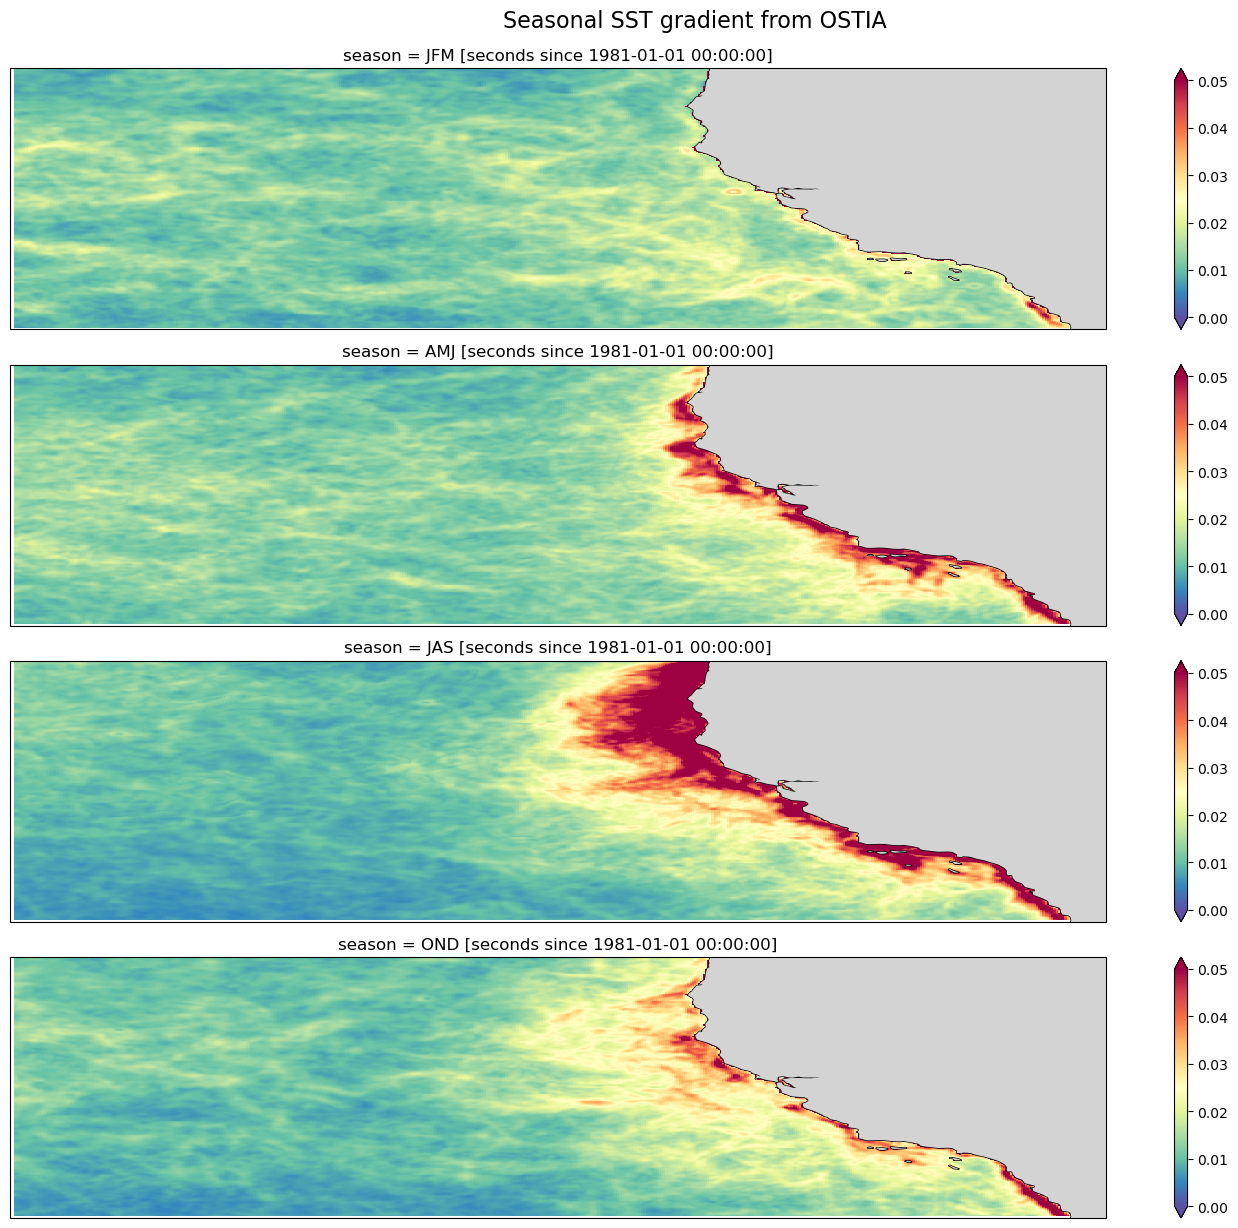

In [19]:
%%time
seasonal_plot(ostia_sst_grad, ostia_sst_grad_seasonal, "Seasonal SST gradient from OSTIA", "ostia_seasonal_grad.png")

#### **Seasonal root-mean-square (RMS) of the SST gradient**

In [20]:
%%time

rms_ostia = np.sqrt(np.square(ostia_sst_grad).groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean()).compute()
print(rms_ostia)

<xarray.DataArray (season: 4, lat: 300, lon: 500)> Size: 5MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.00819474, ..., 0.        ,
         0.        ,        nan],
        ...,
        [       nan,        nan, 0.01118724, ..., 0.        ,
         0.        ,        nan],
        [       nan,        nan, 0.01148486, ..., 0.        ,
         0.        ,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.01128012, ..., 0.        ,
         0.        ,        nan],
...
        [       nan,        nan, 0.01791144, ..., 0.    

CPU times: user 1.91 s, sys: 3.45 ms, total: 1.92 s
Wall time: 2.06 s


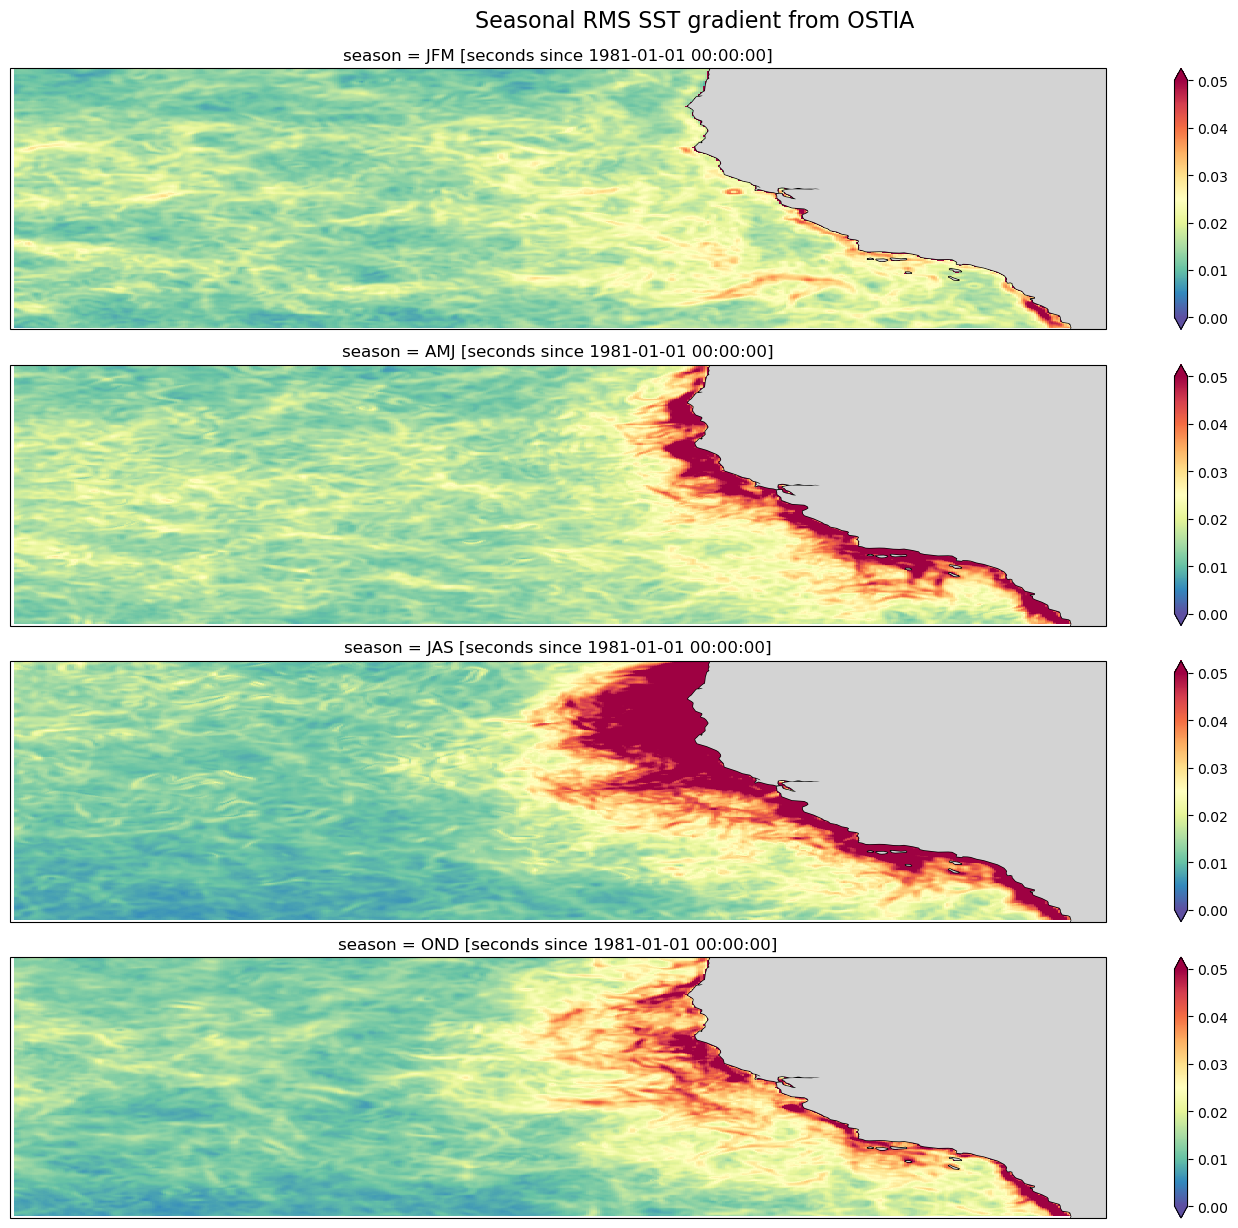

In [21]:
%%time
seasonal_plot(ostia_sst_grad, rms_ostia, "Seasonal RMS SST gradient from OSTIA", "ostia_seasonal_rms_grad.png")

## **Interpolate MUR to OSTIA and compute the gradient for comparison**

#### Interpolate using linear method

In [22]:
# Uses scipy library
mur_interp = mur_subset.interp(lat=ostia_subset.lat, lon=ostia_subset.lon, method="linear")
mur_interp

<xarray.DataArray 'analysed_sst' (time: 1096, lat: 300, lon: 500)> Size: 1GB
dask.array<transpose, shape=(1096, 300, 500), dtype=float64, chunksize=(1, 100, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 9kB 2010-01-01T09:00:00 ... 2012-12-31T09:...
  * lat      (lat) float32 1kB 30.02 30.08 30.12 30.17 ... 44.88 44.92 44.97
  * lon      (lon) float32 2kB -140.0 -139.9 -139.9 ... -115.1 -115.1 -115.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

#### **Compute the SST gradient**

In [23]:
%%time
mur_interp_grad = sst_gradient(mur_interp)

CPU times: user 907 ms, sys: 3.25 ms, total: 910 ms
Wall time: 909 ms


#### **Seasonal average of the SST gradient, with "winter" being January through March**

In [24]:
%%time

sst_grad_seasonal = mur_interp_grad.groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean().compute()
print(sst_grad_seasonal)

<xarray.DataArray (season: 4, lat: 300, lon: 500)> Size: 5MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.01446064, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan, 0.01454296, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.01562059, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.01463198, ...,        nan,
                nan,        nan],
...
        [       nan,        nan, 0.01562066, ...,       

CPU times: user 3.66 s, sys: 194 ms, total: 3.86 s
Wall time: 3.97 s


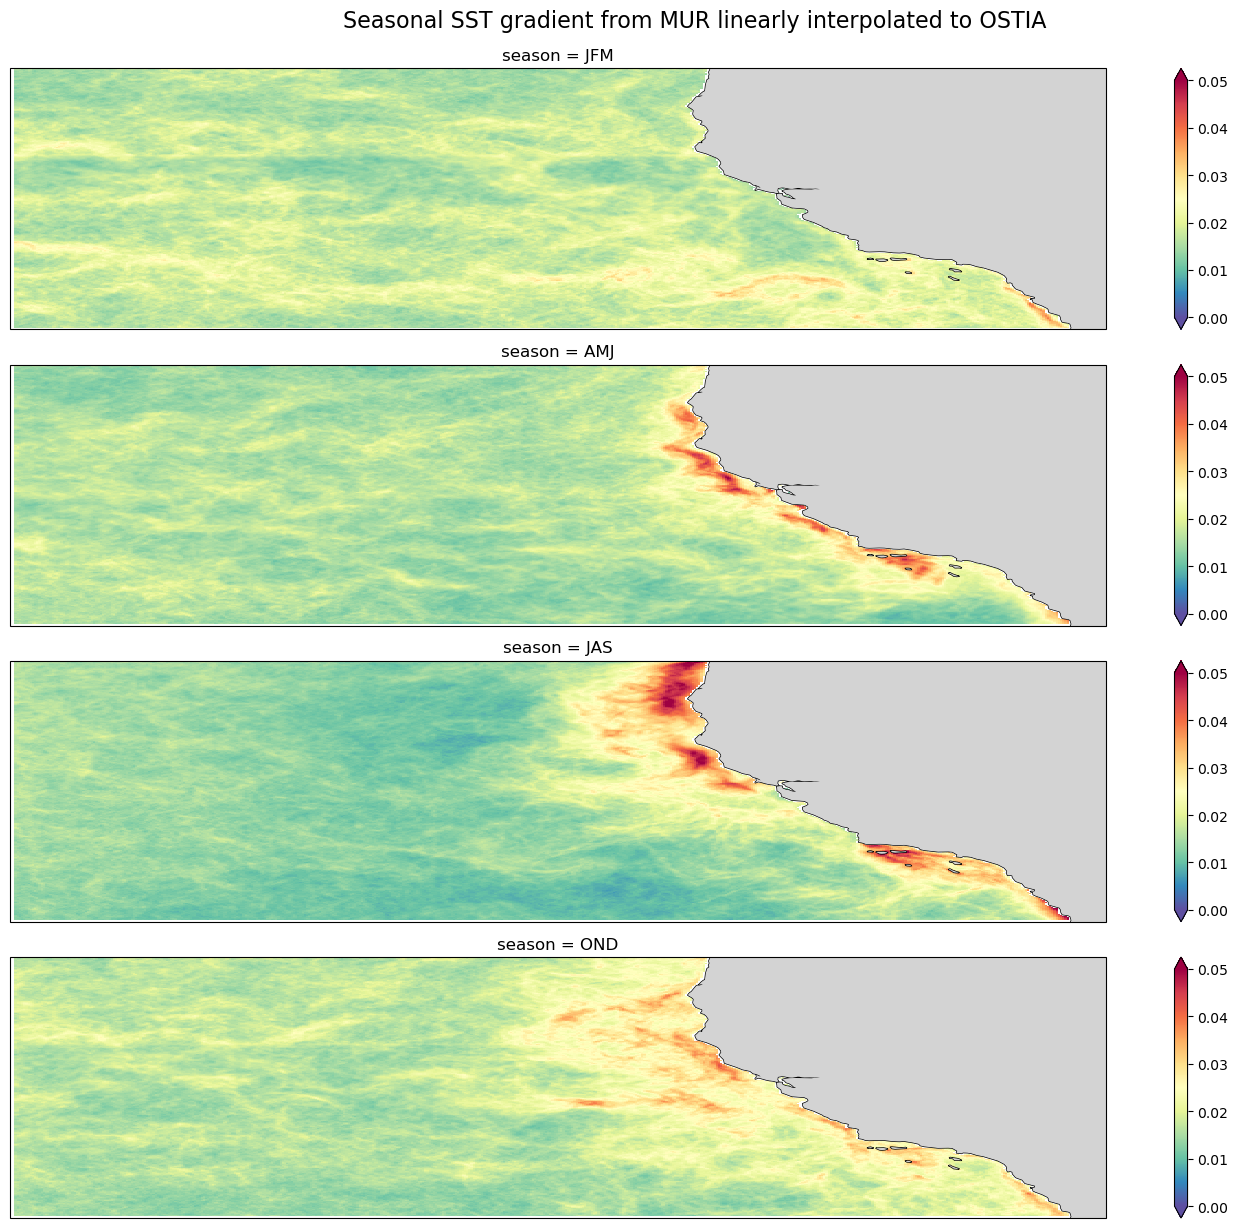

In [25]:
%%time
seasonal_plot(mur_interp, sst_grad_seasonal, "Seasonal SST gradient from MUR linearly interpolated to OSTIA", "mur_linear_seasonal_grad.png")

#### **Seasonal root-mean-square (RMS) of the SST gradient**

In [26]:
%%time

rms_mur = np.sqrt(np.square(mur_interp_grad).groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean()).compute()
print(rms_mur)

<xarray.DataArray (season: 4, lat: 300, lon: 500)> Size: 5MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.01777054, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan, 0.01774095, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.01921158, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.01780784, ...,        nan,
                nan,        nan],
...
        [       nan,        nan, 0.01913766, ...,       

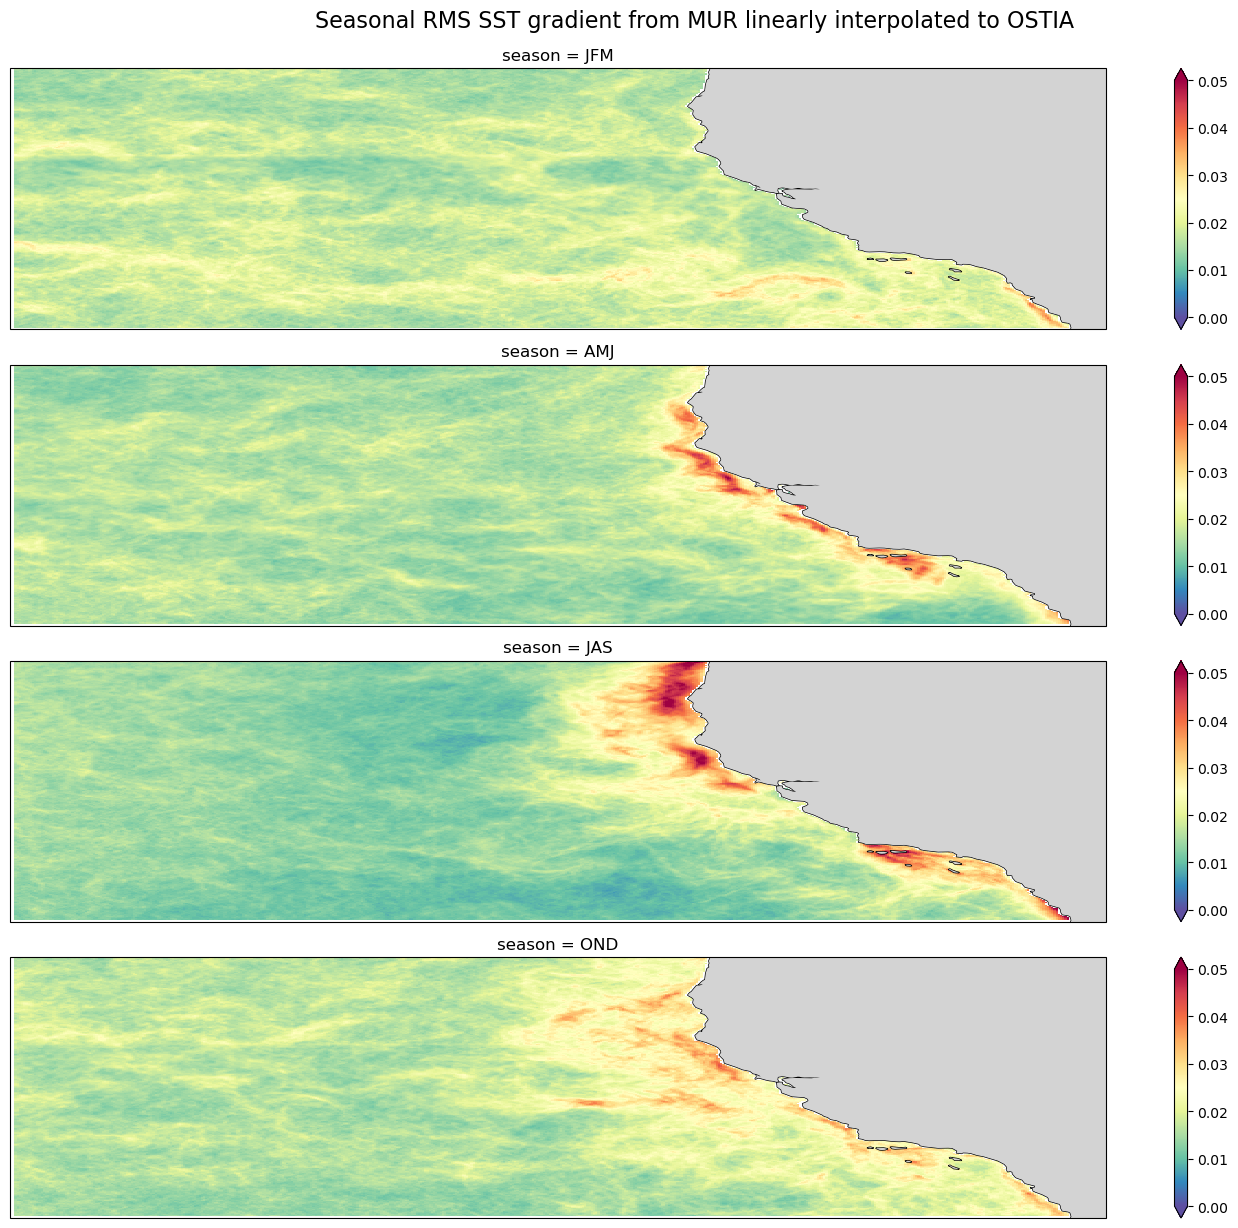

In [29]:
seasonal_plot(mur_interp, sst_grad_seasonal, "Seasonal RMS SST gradient from MUR linearly interpolated to OSTIA", "mur_linear_seasonal_rms_grad.png")

#### **Seasonal histogram of the SST gradient variability (RMS) in OSTIA**

CPU times: user 1.18 s, sys: 2.87 ms, total: 1.18 s
Wall time: 1.19 s


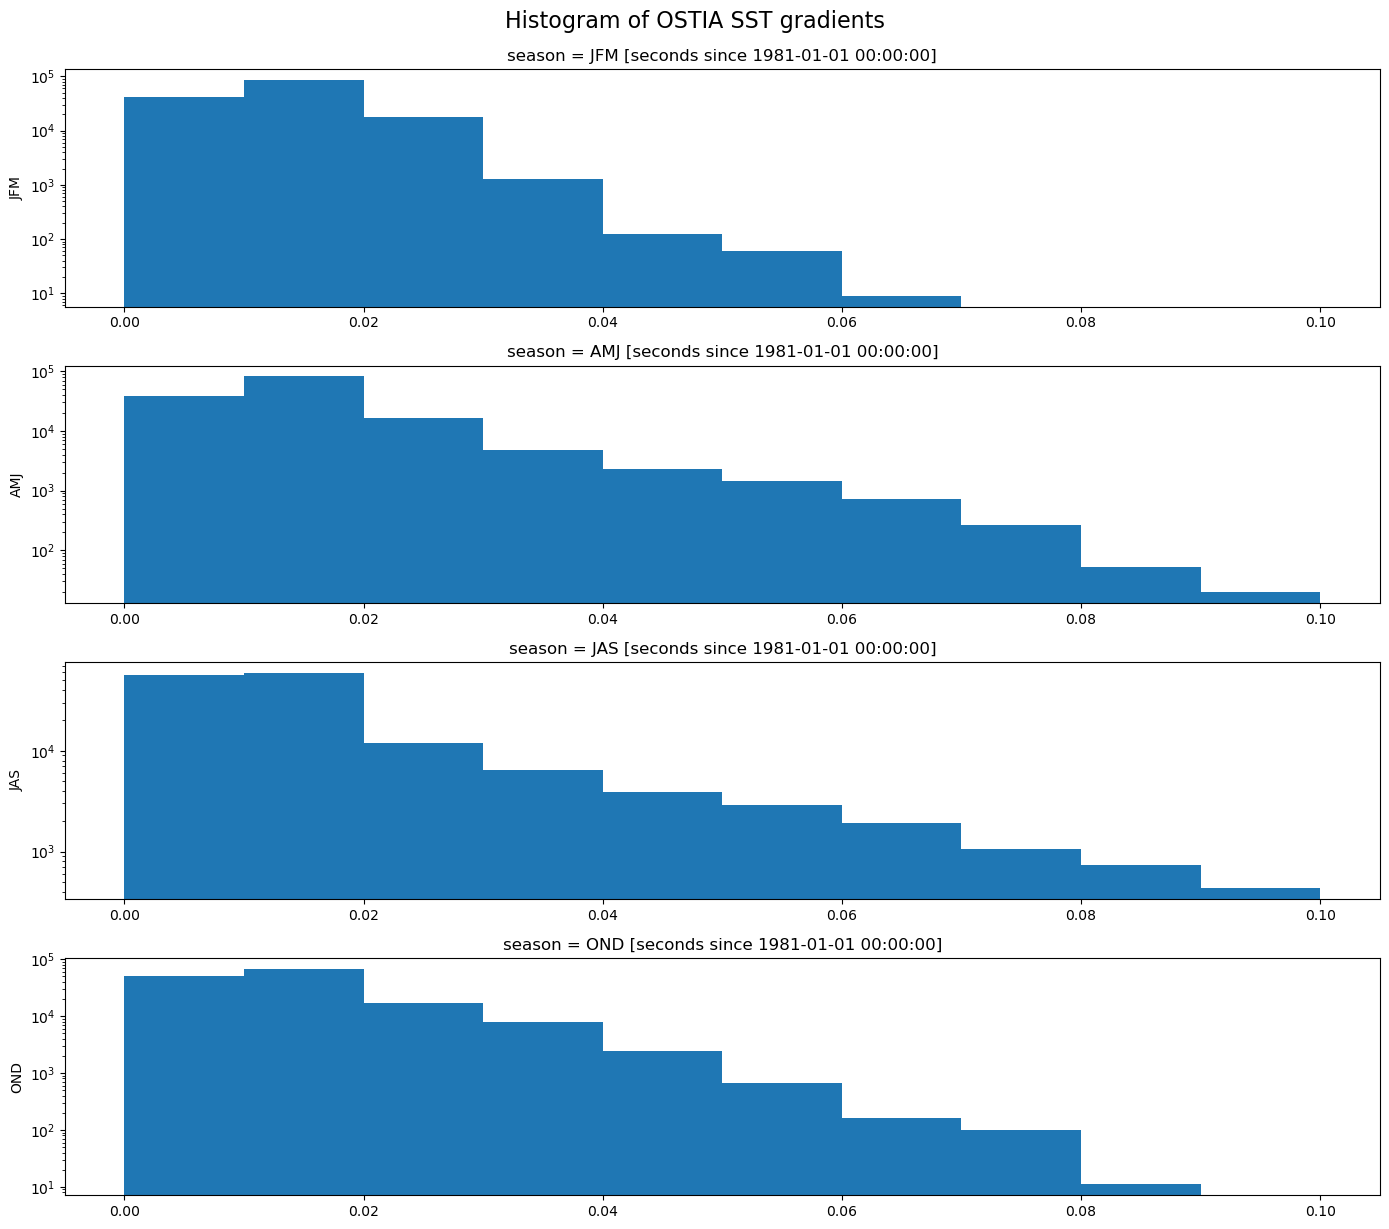

In [30]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    rms_ostia.sel(season=season).plot.hist(
        ax=axes[i],
        range=(0,0.1)
    )
    axes[i].set_yscale('log', base=10)
    axes[i].set_ylabel(season)
plt.tight_layout()
fig.suptitle("Histogram of OSTIA SST gradients", fontsize=16, y=1.02)
plt.savefig("ostia_grad_hist.png")

#### **Seasonal histogram of the SST gradient variability (RMS) in interpolated MUR**

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.19 s


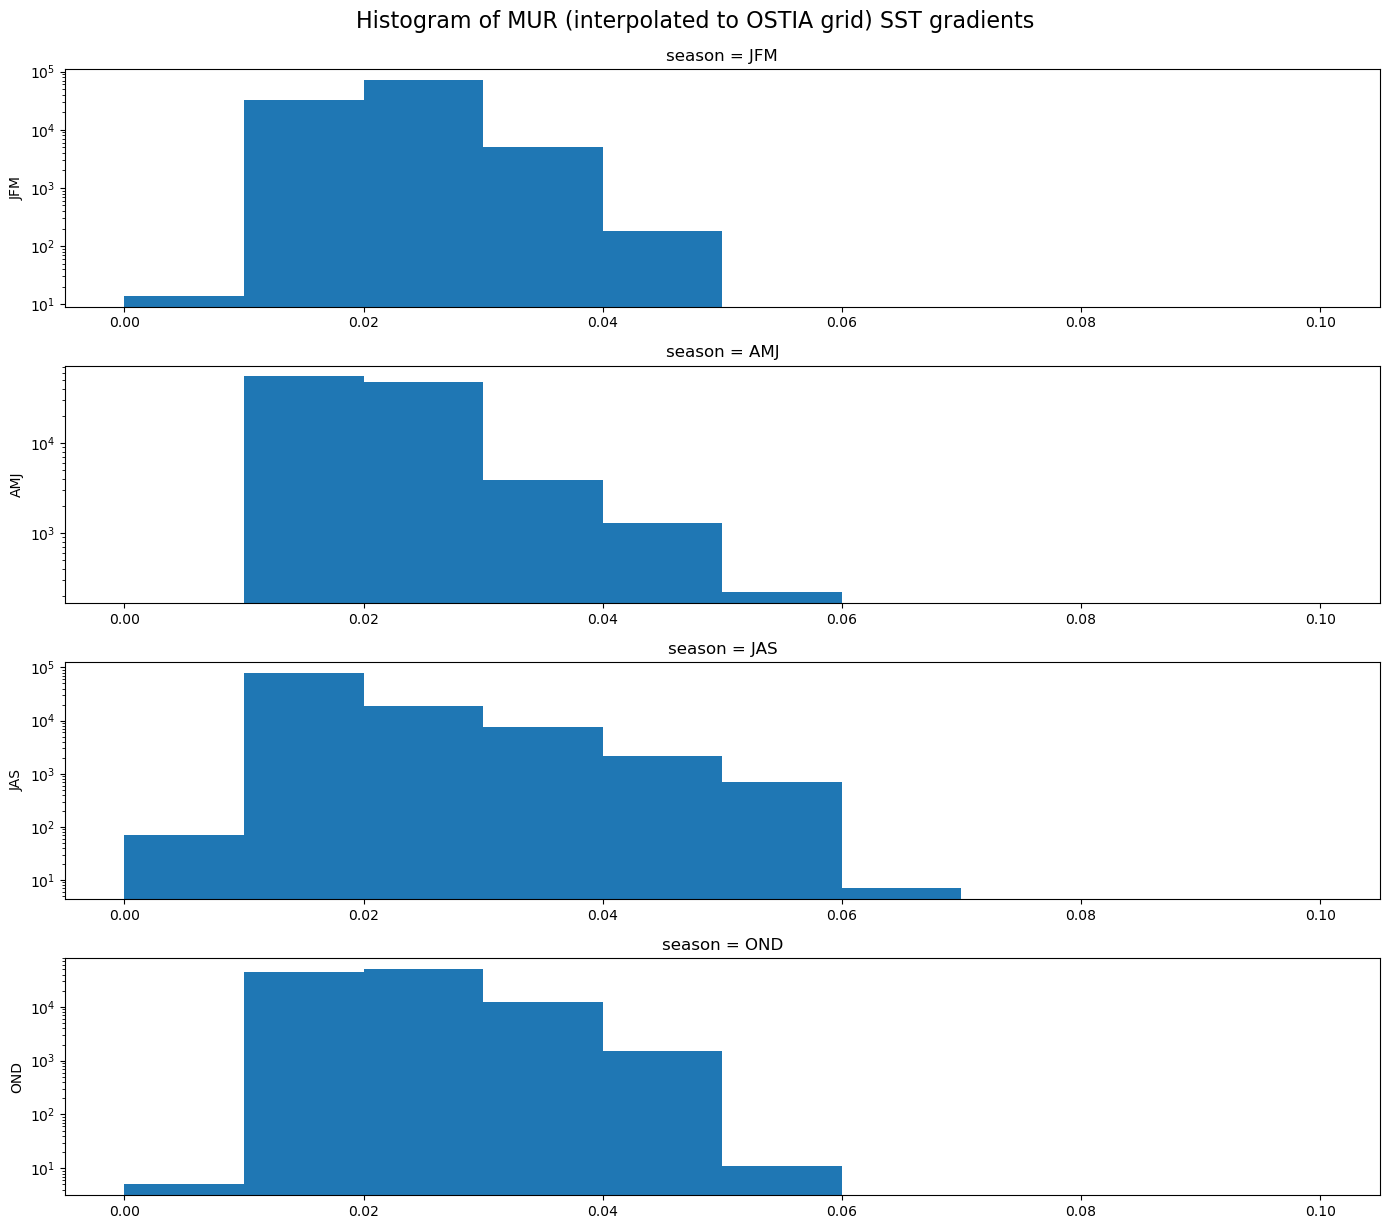

In [31]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    rms_mur.sel(season=season).plot.hist(
        ax=axes[i],
        range=(0,0.1)
    )
    axes[i].set_yscale('log', base=10)
    axes[i].set_ylabel(season)
plt.tight_layout()
fig.suptitle("Histogram of MUR (interpolated to OSTIA grid) SST gradients", fontsize=16, y=1.02)
plt.savefig("mur_grad_hist.png")

*Disclaimer: Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*